In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function
from sympy.matrices import Matrix
import sympy as sp
from TCSPC import *

In [2]:
NADH = Simulation([0.75,0.25],[0.4,4]) #create NADH instance of simulation class
demo_tau = np.linspace(0.2,2,10) #lifetime from 0.2 to 2 ns as demonstration
demo_amp = np.ones(10)/10
DEMO = Simulation(demo_amp,demo_tau)

### DEMO

#### Brief Introduction to Simulation class object:

Input: <ul>
       <li>amp - an array of amplitudes/fractional intensity of mono-exponential components</li>
       <li>tau - an array of lifetimes of mono-exponential components</li>
       <li>IRF characteristics e.g. offset, irfwidth, bg, run_time can be modified,
       but have default values as in the given script</li>
       <li>Histogram properties, e.g. window - x-axis range, n_bins - number of bins</li>
       </ul>
Methods: 

* `multi_exp_data` generate 1 multi exponential curve (1d array of size n_bins)\
* `MC_exp` : generate an array of mono exponential decay curves or 1 multi exponential curve using Monte Carlo method (i.e. random number generator, drawing from normal (IRF) and exponential distribution (decay))
* `plot`   : Plot the generated data. Need to pass a matplotlib `ax` object for plotting.\
Select data simulation function by setting MC =True (`MC_exp`) or False (`multi_exp_data`)

Call the `MC_exp()` method first to get data stored in `self.y`\
`multi_exp_data` would be stored in `self.y2`


### Effect of trimming  In FFT

The data is trimmed to $8 \tau$ as beyond that bg > emitted photon

Note that FFT of trimmed data is almost the same as FFT of original data, and even contain less data points
Both FFT curves deviates from the analytic solution of the Fourier Transform, which may be an artifect of using Discrete transform with not enough data points. Also this may be a result of noise in the data.

Therefore for phasor plots the data will not be trimmed

### Effect of lifetime
Agreement with analytic solution increases with lifetime 

### Effect of bin size
Agreement with analytic solution decreases with bin size (increases with bin number)

In [41]:
def exp_FT(omega,tau):
    '''Analytic solution to Fourier Transform of exponential decay with lifetime tau'''
    W, Tau = np.meshgrid(omega,tau)
    return 1/(1+(W*Tau)**2) + 1j*W*Tau/(1+(W*Tau)**2)

Text(0, 0.5, 'Imaginary component of FFT')

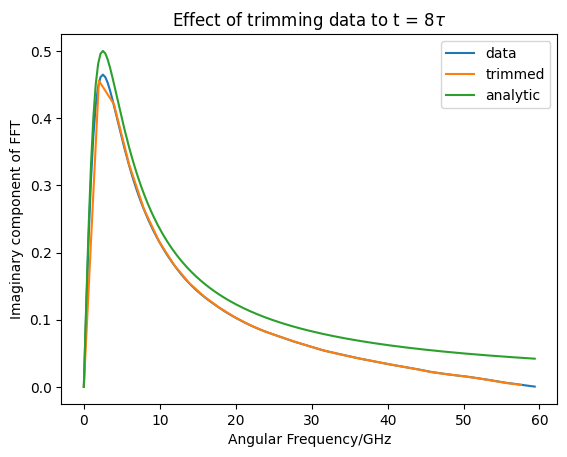

In [5]:
w, p = NADH.phasor_fft(multi = False)
w = w[:int(len(w)/2)]
tau0 = NADH.tau[0]
end = int(tau0*8*NADH.n_bins/NADH.window)
#trim data to 8 tau
y_trim = NADH.y_arr[0,:end]
ker_trim = NADH.ker[:end]
#FFT 
p2 = np.fft.fft(y_trim)/np.sum(y_trim)/np.fft.fft(ker_trim)*np.sum(ker_trim)
w2 = 2*np.pi*np.fft.fftfreq(len(ker_trim),NADH.t[end]/len(ker_trim))
p2 = p2[:int(len(w2)/2)] #just get +ve freq
w2  = w2[:int(len(w2)/2)]

plt.title(r'Effect of trimming data to t = 8$\tau$')
for i in range(1):
    plt.plot(w,-np.imag(p[i,:len(w)]),label = 'data')
    plt.plot(w2,-np.imag(p2),label = 'trimmed')
    plt.plot(w, np.imag(exp_FT(w,NADH.tau)[i]),label = 'analytic')
plt.legend()
plt.xlabel('Angular Frequency/GHz')
plt.ylabel('Imaginary component of FFT')

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_12228/1257124697.py:4: RuntimeWarning: invalid value encountered in divide
  return 1/(1+(W*Tau)**2) + 1j*W*Tau/(+(W*Tau)**2)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

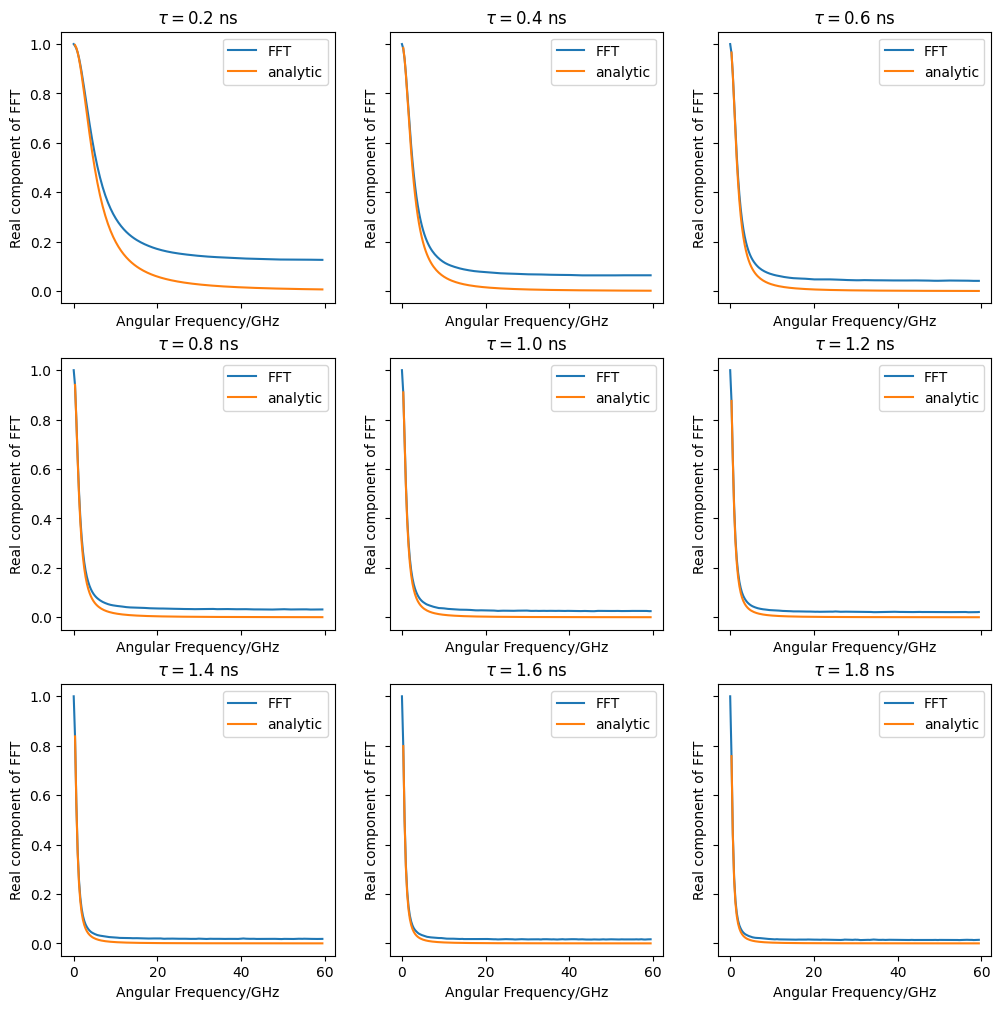

In [37]:
w,p = DEMO.phasor_fft(multi = False)
w = w[:190]
p = p[:,:190]
fig, ax_fft = plt.subplots(3,3,figsize= (12,12),sharex=True, sharey=True)
ax_fft = np.array(ax_fft).flatten()
plt.suptitle('Comparison of analytic FT and FFT at different lifetimes')
for i in range(9):
    ax_fft[i].plot(w,np.real(p[i,:]),label = 'FFT')
    ax_fft[i].plot(w, np.real(exp_FT(w,DEMO.tau)[i]),label = 'analytic')
    ax_fft[i].set_title(r'$\tau = $' + f'{DEMO.tau[i]:.1f} ns')
    ax_fft[i].legend()
    ax_fft[i].set_xlabel('Angular Frequency/GHz')
    ax_fft[i].set_ylabel('Real component of FFT')
plt.tight_layout

### Effect of Number of bins 

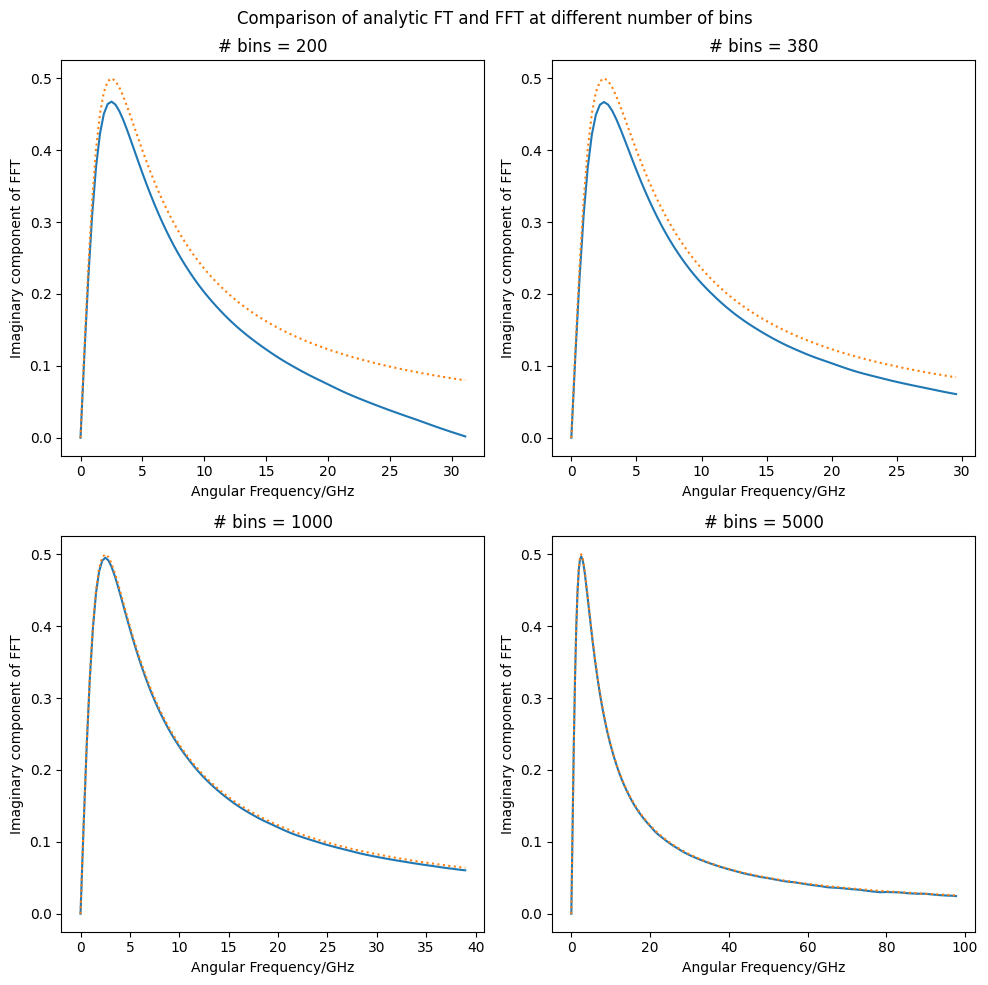

In [49]:
DEMO.MC_exp() #generate simulatioopn data for 10 separate mono exp decays
n = 1 #nth component
t_tot = DEMO.t_tot[n]
fig, ax_bin = plt.subplots(2,2,figsize = (10,10))
ax_bin = np.array(ax_bin).flatten()
n_bins = [200,380,1000,5000]
plt.suptitle('Comparison of analytic FT and FFT at different number of bins')
for i in range(len(n_bins)):
    t = np.linspace(0,DEMO.window,n_bins[i])
    ker = stats.norm.pdf(t,loc = DEMO.t0,scale = DEMO.irfwidth)
    hist, bin = np.histogram(t_tot,n_bins[i],range = (0,DEMO.window))
    w, p = phasor_fft(hist,ker,DEMO.window/n_bins[i])
    end = int(n_bins[i]/2**(i+1))
    ax_bin[i].set_title(f'# bins = {n_bins[i]}')
    ax_bin[i].plot(w[:end],-np.imag(p[:end]))
    ax_bin[i].plot(w[:end],np.imag(exp_FT(w[:end],DEMO.tau[n])[0]),':')
    ax_bin[i].set_xlabel('Angular Frequency/GHz')
    ax_bin[i].set_ylabel('Imaginary component of FFT')

plt.tight_layout()
    

### Deconvolution for non-linear fitting

Note at around 20ns, boundary effects, low-count statistic and noise would result in such poor behaviour. The deconvolved data should be trimmed before fitting

In [ ]:
t, y_NADH = NADH.MC_exp()
fig,ax = plt.subplots(1,1)
NADH.plot(ax) #plot mono exp component
NADH.plot(ax,multi=True) #plot multi exp 
NADH.plot(ax,multi=True,deconv=True) #plot data deconvolved with IRF
handles, labels = ax.get_legend_handles_labels()
labels[-1] = 'Deconvolved'
ax.legend(labels)

In [ ]:
handles, labels = ax.get_legend_handles_labels()
labels

In [12]:
DEMO.y_arr/np.sum(DEMO.y_arr,axis = 1)

ValueError: operands could not be broadcast together with shapes (10,380) (10,) 

array([2999780., 2999780., 2999780., 2999780., 2999780., 2999780.,
       2999779., 2999768., 2999731., 2999602.])